In [1]:
# Imports
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

if not tf.test.gpu_device_name():
    warnings.warn("No GPU found.")
else: 
    print('Default gpu device: {}' .format(tf.test.gpu_device_name()))

gpus = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

/tmp/ipykernel_41165/2589086162.py:19: UserWarning: No GPU found.
  warnings.warn("No GPU found.")
2023-05-22 13:24:47.658049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 13:24:47.679000: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-22 13:24:47.679015: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 9712c8604b07
2023-05-22 13:24:47.679018: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 9712c8604b07
2023-05-22 13:24:47.679064: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
202

In [2]:
def load_data(filename, resample=False, integer_timestamp=False):
    # Load in the data
    df = pd.read_csv(filename, parse_dates=['timestamp'])
    
    # drop nan values
    df = df.dropna()

    # set timestamp as index and drop timestamp column
    df.index = pd.to_datetime(df['timestamp'], format='%Y.%m.%d %H:%M:%S')
    df = df.drop(columns=['timestamp'])

    if(resample):
        # Resample the DataFrame to 4 minutes frequency if needed
        df = df.resample('4T').mean()
    if(integer_timestamp):
        # use if the timestamp is a integer
        to_datetime = lambda x: datetime.datetime.fromtimestamp(x/1000.0)
        df['timestamp'] = df['timestamp'].astype(float)
        df['timestamp'] = df['timestamp'].apply(to_datetime)


    return df

df_laptop = load_data(r'../data/multiple_devices/new_weeks/pc_jarno_4w_allsame.csv')
df_box = load_data(r'../data/multiple_devices/new_weeks/synthetic_test_4w_allsame.csv')
df_pc = load_data(r'../data/multiple_devices/new_weeks/PCSynth.csv')
df_printer = load_data(r'../data/multiple_devices/new_weeks/PrinterSynth.csv')
df_phone = load_data(r'../data/multiple_devices/new_weeks/PhoneSynth.csv')


def add_time_features(df):
    # add hour, minute, day of the week and month parameters
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    # df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    # df['month'] = df.index.month
    return df

# add time features to the datasets
df_laptop = add_time_features(df_laptop)
df_box = add_time_features(df_box)
df_pc = add_time_features(df_pc)
df_printer = add_time_features(df_printer)
df_phone = add_time_features(df_phone)

# reset the index so it is not a timestamp index but just a number
df_laptop = df_laptop.reset_index()
df_box = df_box.reset_index()
df_pc = df_pc.reset_index()
df_printer = df_printer.reset_index()
df_phone = df_phone.reset_index()

# create a list of the dataframes
dfs = [df_box,df_laptop,df_pc,df_phone,df_printer]

# loop through the list of dataframes and assign a value to a new column called 'device'
for i, df in enumerate(dfs):
    df['device'] = i


combined_df = pd.concat([df_box,df_laptop,df_pc,df_phone,df_printer])
combined_df = combined_df.drop(columns=['timestamp'])


# print(combined_df)
# print("done")
print(df_laptop)
df_box.head()

                timestamp  state  hour  minute  day_of_week  device
0     2023-01-02 00:00:00      1     0       0            0       1
1     2023-01-02 00:04:00      1     0       4            0       1
2     2023-01-02 00:08:00      1     0       8            0       1
3     2023-01-02 00:12:00      1     0      12            0       1
4     2023-01-02 00:16:00      1     0      16            0       1
...                   ...    ...   ...     ...          ...     ...
10075 2023-01-29 23:40:00      0    23      40            6       1
10076 2023-01-29 23:44:00      0    23      44            6       1
10077 2023-01-29 23:48:00      0    23      48            6       1
10078 2023-01-29 23:52:00      0    23      52            6       1
10079 2023-01-29 23:56:00      0    23      56            6       1

[10080 rows x 6 columns]


,timestamp,state,hour,minute,day_of_week,device
0,2023-01-02 00:00:00,0.0,0,0,0,0
1,2023-01-02 00:04:00,0.0,0,4,0,0
2,2023-01-02 00:08:00,0.0,0,8,0,0
3,2023-01-02 00:12:00,0.0,0,12,0,0
4,2023-01-02 00:16:00,0.0,0,16,0,0


In [3]:
# # add column for state
# df['state'] = np.where(df['power'] > 5, 1, 0)
# # df['state'] = np.where(df['power'] > 50, 1, 0)
# df = df.drop(columns=['power']) # not sure if power is a valuable parameter

In [4]:

combined_df.head()

,state,hour,minute,day_of_week,device
0,0.0,0,0,0,0
1,0.0,0,4,0,0
2,0.0,0,8,0,0
3,0.0,0,12,0,0
4,0.0,0,16,0,0


In [5]:
combined_df.describe()

,state,hour,minute,day_of_week,device
count,50400.000000,50400.000000,50400.000000,50400.00000,50400.000000
mean,0.345952,11.500000,28.000000,3.00000,2.000000
std,0.475682,6.922255,17.282147,2.00002,1.414228
min,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,5.750000,12.000000,1.00000,1.000000
50%,0.000000,11.500000,28.000000,3.00000,2.000000
75%,1.000000,17.250000,44.000000,5.00000,3.000000
max,1.000000,23.000000,56.000000,6.00000,4.000000


In [6]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# drop timestamp column
df_laptop = df_laptop.drop(columns=['timestamp'])
df_box = df_box.drop(columns=['timestamp'])
df_pc = df_pc.drop(columns=['timestamp'])
df_printer = df_printer.drop(columns=['timestamp'])
df_phone = df_phone.drop(columns=['timestamp'])

# normalize our features, scale on all values first (combined)
scaler = MinMaxScaler(feature_range=(-1,1))
combined_df[['hour','minute','day_of_week', 'device']] = scaler.fit_transform(combined_df[['hour','minute','day_of_week','device']])

# scale the seperate data
df_box[['hour','minute','day_of_week', 'device']] = scaler.transform(df_box[['hour','minute','day_of_week', 'device']])
df_laptop[['hour','minute','day_of_week', 'device']] = scaler.transform(df_laptop[['hour','minute','day_of_week', 'device']])
df_pc[['hour','minute','day_of_week', 'device']] = scaler.transform(df_pc[['hour','minute','day_of_week', 'device']])
df_printer[['hour','minute','day_of_week', 'device']] = scaler.transform(df_printer[['hour','minute','day_of_week', 'device']])
df_phone[['hour','minute','day_of_week', 'device']] = scaler.transform(df_phone[['hour','minute','day_of_week', 'device']])

joblib.dump(scaler, './scaler_boxpc.gz') # save the scaler

print(df_box)
print(df_laptop)
print(df_pc)
print(df_printer)
print(df_phone)

       state  hour    minute  day_of_week  device
0        0.0  -1.0 -1.000000         -1.0    -1.0
1        0.0  -1.0 -0.857143         -1.0    -1.0
2        0.0  -1.0 -0.714286         -1.0    -1.0
3        0.0  -1.0 -0.571429         -1.0    -1.0
4        0.0  -1.0 -0.428571         -1.0    -1.0
...      ...   ...       ...          ...     ...
10075    1.0   1.0  0.428571          1.0    -1.0
10076    1.0   1.0  0.571429          1.0    -1.0
10077    0.0   1.0  0.714286          1.0    -1.0
10078    0.0   1.0  0.857143          1.0    -1.0
10079    0.0   1.0  1.000000          1.0    -1.0

[10080 rows x 5 columns]
       state  hour    minute  day_of_week  device
0          1  -1.0 -1.000000         -1.0    -0.5
1          1  -1.0 -0.857143         -1.0    -0.5
2          1  -1.0 -0.714286         -1.0    -0.5
3          1  -1.0 -0.571429         -1.0    -0.5
4          1  -1.0 -0.428571         -1.0    -0.5
...      ...   ...       ...          ...     ...
10075      0   1.0  0.42

In [7]:
def split_train_test(df):
    train_size = int(len(df) * 0.6)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    return train, test

# split the datasets into training and testing sets
train, test = split_train_test(df_laptop)
# train_sille, test_sille = split_train_test(df_generated2)
train_box, test_box = split_train_test(df_box)
train_pc, test_pc = split_train_test(df_pc)
train_printer, test_printer = split_train_test(df_printer)
train_phone, test_phone = split_train_test(df_phone)

# print the size of the training and testing sets for each dataset
print(len(train), len(test))
# print(len(train_sille), len(test_sille))
print(len(train_box), len(test_box))
print(len(train_pc), len(test_pc))
print(len(train_printer), len(test_printer))
print(len(train_phone), len(test_phone))

6048 4032
6048 4032
6048 4032
6048 4032
6048 4032


In [8]:
train.shape, test.shape

((6048, 5), (4032, 5))

In [9]:
def create_dataset(input, output, time_steps=1):
    x,y = [], []
    for i in range(len(input) - time_steps):
        v = input.iloc[i:(i + time_steps)].values
        x.append(v)
        y.append(output.iloc[i + time_steps])
    return np.array(x), np.array(y)

(17640, 2520, 5) (7560, 2520, 5) (17640,) (7560,)


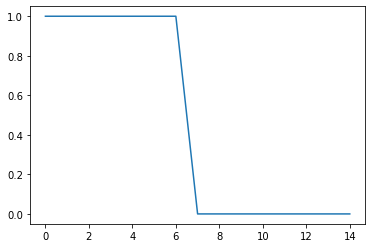

In [10]:
time_steps = 2520 # 4 minutes for 1 week = 2520, 1 hour 168, 30 minutes 336, 15 minutes 672

from sklearn import preprocessing

input_train, output_train = create_dataset(train,train.state,time_steps)
input_test, output_test = create_dataset(test,test.state,time_steps)

input_train_box, output_train_box = create_dataset(train_box,train_box.state,time_steps)
input_test_box, output_test_box = create_dataset(test_box,test_box.state,time_steps)

input_train_pc, output_train_pc = create_dataset(train_pc,train_pc.state,time_steps)
input_test_pc, output_test_pc = create_dataset(test_pc,test_pc.state,time_steps)

input_train_printer, output_train_printer = create_dataset(train_printer,train_printer.state,time_steps)
input_test_printer, output_test_printer = create_dataset(test_printer,test_printer.state,time_steps)

input_train_phone, output_train_phone = create_dataset(train_phone,train_phone.state,time_steps)
input_test_phone, output_test_phone = create_dataset(test_phone,test_phone.state,time_steps)

# this needs to be a float for when edges of signal are rounded
output_train = output_train.astype(float)

# concatenate the different training and test sets with eachother
input_train_conc = np.concatenate((input_train,input_train_box,input_train_pc,input_train_printer,input_train_phone),axis=0)
input_test_conc = np.concatenate((input_test,input_test_box,input_test_pc,input_test_printer,input_test_phone),axis=0)
output_train_conc = np.concatenate((output_train,output_train_box,output_train_pc,output_train_printer,output_train_phone),axis=0)

plt.plot(output_train_conc[25:40])
# determines with how munch the values should minimaly be changed
min_slope = 0.2
# percentage of previous values to update
pct_prev_vals = 0.5
# counts how long ago the last edge occured
last_change = 1
# the first value
previous = output_train_conc[0]

for i in range(1,len(output_train_conc)):
    # if an edge is detected
    if(output_train_conc[i] != previous):
        # calculate the number of previous values to update based on the percentage and maximum limit
        num_prev_vals = min(int(pct_prev_vals * last_change), 4)
        # calculate the slope based on the number of previous values being updated
        slope = min(min_slope * (4 // num_prev_vals),0.3)
        for j in range(1,num_prev_vals+1):
            if(output_train_conc[i] == 1): # if the value changes to 1
                # replace the value with its new value
                # this is calculated based on the slope times how far the value is from the edge
                output_train_conc[i - j] += slope*((num_prev_vals+1)-j) 
            else: # if the value changes to 0
                output_train_conc[i - j] -= slope*((num_prev_vals+1)-j)
        last_change = 1
    else:
        last_change += 1
    previous = output_train_conc[i] # store the last value
    
# print and plot to see if rounding happens properly
# print(output_train_conc[35:40])
# plt.plot(output_train_conc[25:40])


output_test_conc = np.concatenate((output_test,output_test_box,output_test_pc,output_test_printer,output_test_phone),axis=0)
print(input_train_conc.shape, input_test_conc.shape, output_train_conc.shape, output_test_conc.shape)

In [11]:
model = Sequential()
model.add(Bidirectional(LSTM(8, input_shape=(input_train_conc.shape[1],input_train_conc.shape[2]),return_sequences=True,activation='tanh')))# , input_shape=(input_train.shape[1],input_train.shape[2]), return_sequences=True)
model.add(Dropout(0.25))
model.add(
    Bidirectional(LSTM(2,activation='tanh',recurrent_dropout=0))
)
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001), metrics= ["accuracy"])

In [12]:
history = model.fit(input_train_conc, output_train_conc, epochs=10,batch_size=2)
model.summary()

2023-05-22 13:24:52.655217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1942/8820 [=====>........................] - ETA: 1:01:13 - loss: 0.1494 - accuracy: 0.9549

KeyboardInterrupt: 

In [ ]:
# make predictions for input data
prediction = model.predict(input_test_conc)

In [ ]:
# compare prediction to expected output (output without rounded edges)
plt.plot(prediction)
plt.plot(output_test_conc)

In [ ]:
# zoom in on part of plot
plt.plot(prediction[0:300])
plt.plot(output_test_conc[0:300])

In [ ]:
# save model
model.save('./saved_models/models_day_month/all_devicesV4/')

In [ ]:
# save model in tar.gz
!tar chvfz models_day_month.tar.gz ./saved_models/models_day_month*

In [ ]:
# make a backup of the entire server
# !tar chvfz jupyter_backup.tar.gz ../../../shared/
!tar chvfz notebook_backup.tar.gz ./prediction_state_day_month-softmax-Copy2.ipynb